In [3]:
# Cell 1: Import all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, f1_score

In [6]:
# Cell 2: Load the cleaned and feature-engineered dataset

# Define the path relative to the notebooks/ directory
INPUT_FILE = '/home/adam/Dokumenty/projects/car_insurance_stats/data/processed/car_insurance_claim_clean.csv'
data = pd.read_csv(INPUT_FILE)

print("Data loaded successfully.")
print(f"Dataset shape: {data.shape}")
print("\nFirst 5 rows of the clean data:")
data.head()

Data loaded successfully.
Dataset shape: (10000, 21)

First 5 rows of the clean data:


,id,age,gender,race,driving_experience,education,income,vehicle_year,vehicle_type,credit_score,...,vehicle_ownership,married,children,Response,postal_code,speeding_violations,duis,past_accidents,Mileage_Category,Credit_to_Mileage_Ratio
0,569520,65+,female,majority,0-9y,high school,upper class,after 2015,sedan,0.629027,...,1,0,1,0,10238,0,0,0,Střední_Nájezd,0.000052
1,750365,16-25,male,majority,0-9y,none,poverty,before 2015,sedan,0.357757,...,0,0,0,1,10238,0,0,0,Vysoký_Nájezd,0.000022
2,199901,16-25,female,majority,0-9y,high school,working class,before 2015,sedan,0.493146,...,1,0,0,0,10238,0,0,0,Nízký_Nájezd,0.000045
3,478866,16-25,male,majority,0-9y,university,working class,before 2015,sedan,0.206013,...,1,0,1,0,32765,0,0,0,Nízký_Nájezd,0.000019
4,731664,26-39,male,majority,10-19y,none,working class,before 2015,sedan,0.388366,...,1,0,0,1,32765,2,0,1,Střední_Nájezd,0.000032


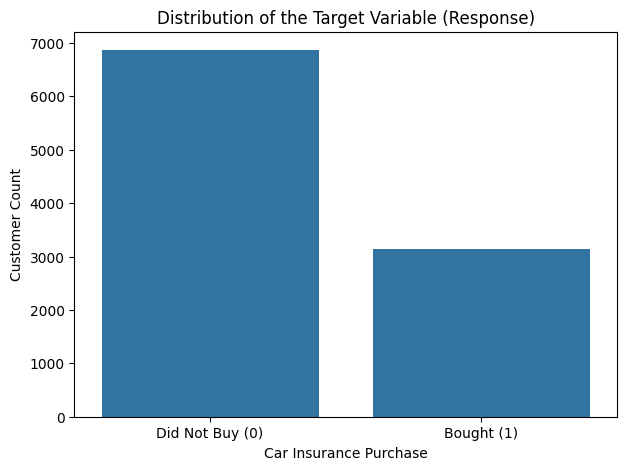

Proportion of positive responses (Response=1): 31.33%


In [7]:
# Cell 3: Visualize the target variable ('Response') to confirm class imbalance

plt.figure(figsize=(7, 5))
sns.countplot(x='Response', data=data)
plt.title('Distribution of the Target Variable (Response)')
plt.xticks([0, 1], ['Did Not Buy (0)', 'Bought (1)'])
plt.ylabel('Customer Count')
plt.xlabel('Car Insurance Purchase')
plt.show()

# Calculate the proportion of the positive class (Response=1)
response_rate = data['Response'].mean()
print(f"Proportion of positive responses (Response=1): {response_rate:.2%}")

In [8]:
# Cell 4: Categorical Encoding (One-Hot Encoding)

# List of categorical columns to encode, including the new 'Mileage_Category'
categorical_cols = [
    'age', 'gender', 'race', 'driving_experience', 
    'education', 'income', 'vehicle_year', 'vehicle_type', 
    'Mileage_Category'
]

# Drop irrelevant unique identifier columns ('id', 'postal_code')
data_to_encode = data.drop(columns=['id', 'postal_code'])

# Perform One-Hot Encoding. drop_first=True to avoid multicollinearity.
data_encoded = pd.get_dummies(data_to_encode, columns=categorical_cols, drop_first=True) 

print(f"Data shape after One-Hot Encoding: {data_encoded.shape}")

Data shape after One-Hot Encoding: (10000, 27)


In [9]:
# Cell 5: Define X (features) and y (target) and split data

# Define features (X) and target (y)
X = data_encoded.drop('Response', axis=1)
y = data_encoded['Response']

# Split data (70% Train for modeling, 30% Test for evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")

Training set size: 7000 rows
Test set size: 3000 rows


In [10]:
# Cell 6: Fit Logistic Regression Model 1 (Key Factors)

# Define the predictors for the model based on the initial hypothesis
predictors = [
    'age_26-39', 'age_40-64', 'age_65+',
    'gender_male',
    'past_accidents', 
    'vehicle_ownership',
    'Mileage_Category_Střední_Nájezd', 'Mileage_Category_Vysoký_Nájezd',
    'Credit_to_Mileage_Ratio'
]

# Ensure all selected predictors exist in the training data after encoding
final_predictors = [p for p in predictors if p in X_train.columns]

# Add Constant (Intercept) for statsmodels
X_train_model1 = sm.add_constant(X_train[final_predictors])

# Fit the Logit Model
logit_model1 = sm.Logit(y_train, X_train_model1)
# disp=False suppresses the iteration output during fitting
result1 = logit_model1.fit(disp=False) 

print("Model training completed.")

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
# Cell 7: Print Model Summary to evaluate significance (P-values) and coefficients

print("Logistic Regression: Model 1 Results (Key Factors)\n" + "="*60)
print(result1.summary())

# Interpretation Helper: Odds Ratios (e^coef)
print("\nOdds Ratios (Interpretation of change in odds for Response=1):")
print(np.exp(result1.params).sort_values(ascending=False))

In [ ]:
# Cell 8: Model Evaluation on the Test Set

# 1. Prediction on the test set
X_test_model1 = sm.add_constant(X_test[final_predictors], has_constant='add')
predictions_prob = result1.predict(X_test_model1)
predictions_class = (predictions_prob >= 0.5).astype(int) # Standard threshold of 0.5

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, predictions_class)
print("\nConfusion Matrix (Threshold 0.5):")
# [ [TN, FP], [FN, TP] ]
print(conf_matrix)

TN, FP, FN, TP = conf_matrix.ravel()

# 3. Calculate Key Metrics
accuracy = accuracy_score(y_test, predictions_class)
recall = recall_score(y_test, predictions_class)
specificity = TN / (TN + FP)
f1 = f1_score(y_test, predictions_class)

print(f"\nClassification Metrics:")
print(f"Accuracy (Overall Correctness): {accuracy:.4f}")
print(f"Recall (Sensitivity - True Positive Rate): {recall:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"F1-Score (Harmonic Mean of Precision and Recall): {f1:.4f}")

# Final Note: Explain why Recall is important due to the class imbalance.
print("\nNote on Recall: Since the 'Did Not Buy' class (0) heavily outweighs the 'Bought' class (1), high Accuracy can be misleading. Recall is critical because it measures the model's ability to capture the actual positive customers (True Buyers), minimizing missed business opportunities (False Negatives).")